<h1 style="color: red; text-align:center">Publications of the Society for the Encouragement of National Industry</h1>
<hr>
<h3>❖ Authors:</h3>
<p>IZMOUH Mariam<br>TATI Mohammed</p>
<p style="text-align: right;"><b>11-JUN | <span style="color: green;">2023</span></b></p>

<h2 style="color: green">Importing libraries needed</h2>

In [0]:
# Data manipilation
import pandas as pd

# Scrapping tool
from bs4 import BeautifulSoup
from lxml import etree

# progress bar
from tqdm import tqdm

# To get the HTTP requests
import requests

# To make sure we are scrapping the right data
import re 

<h2 style="color: green">Data Scraping</h2>

In [0]:
def scraper():
    # DataFrame
    data = {"id": [], "year": [], "article": [], "theme": []}
    
    # Initialize the progress bar once
    total_iterations = 115
    progress_bar = tqdm(total=total_iterations, desc='Progress', unit='iteration')
    
    # Counter
    count = 0
    
    for i in range(1, 116):
        progress_bar.update(1)
        # HTML Page to scrap (1802-1910)
        html = requests.get(f"https://cnum.cnam.fr/pgi/redir.php?onglet=d&ident=BSPI.{i}").text
        
        # Parsing the HTML
        soup = BeautifulSoup(html, "html.parser")
        dom = etree.HTML(str(soup))
        
        # Getting the <span> tags that containes the data needed
        spans = soup.find_all('span', class_='row-label with-list2')
        
        for span in spans:
            # getting the list of articales
            for u in span.find_next_sibling('ul'):

                a_tags = u.find_all('a')

                for a in a_tags:
                    count += 1
                    # Record Id
                    record_id = "IT"+"{:06d}".format(count)
                    data["id"].append(record_id)
                    
                    # Year
                    year = dom.xpath('/html/body/div[1]/div/div[2]/ul/li[4]/text()')[0]
                    data['year'].append(year)
                    
                    # Article
                    data["article"].append(a.text)
                    
                    # Theme
                    data["theme"].append(span.text)
            
    return data

<h3>Generating the data</h3>

In [0]:
df = pd.DataFrame(scraper())

Progress: 100%|██████████| 115/115 [00:52<00:00,  2.20iteration/s]


In [0]:
# Saving the data as CSV fo further precessing
df.head()

,id,year,article,theme
0,IT000001,> 1802. An XI [1802]. 1e année,EXTRAIT des procès-verbaux des séances du Cons...,CONSEIL D'ADMINISTRATION (p.5)
1,IT000002,> 1802. An XI [1802]. 1e année,PROGRAMMES des prix proposés parla Société (p.6),CONSEIL D'ADMINISTRATION (p.5)
2,IT000003,> 1802. An XI [1802]. 1e année,EXTRAIT d'un rapport fait à la Société d Encou...,ARTS MÉCANIQUES (p.7)
3,IT000004,> 1802. An XI [1802]. 1e année,PROCÉDÉ pour presser et former les chapeaux de...,ARTS MÉCANIQUES (p.7)
4,IT000005,> 1802. An XI [1802]. 1e année,"RAPPORT fait , au nom du Comité des arts mécan...",ARTS MÉCANIQUES (p.7)


In [0]:
df.shape[0]

Out[84]: 128953

<h2 style="color: green">Data Cleaning Using Spark</h2>

In [0]:
%sql
select * from hive_metastore.default.data  limit 5;  

id,year,article,theme
IT000001,> 1802. An XI [1802]. 1e année,EXTRAIT des procès-verbaux des séances du Conseil (p.5),CONSEIL D'ADMINISTRATION (p.5)
IT000002,> 1802. An XI [1802]. 1e année,PROGRAMMES des prix proposés parla Société (p.6),CONSEIL D'ADMINISTRATION (p.5)
IT000003,> 1802. An XI [1802]. 1e année,"EXTRAIT d'un rapport fait à la Société d Encouragement, au nom du Comité des arts mécaniques, par le C. Molard, sur les machines a filer la soie (p.7)",ARTS MÉCANIQUES (p.7)
IT000004,> 1802. An XI [1802]. 1e année,PROCÉDÉ pour presser et former les chapeaux de paille (p.8),ARTS MÉCANIQUES (p.7)
IT000005,> 1802. An XI [1802]. 1e année,"RAPPORT fait , au nom du Comité des arts mécaniques , sur la proposition du C. relative a un nouveau genre de construction, navale (p.11)",ARTS MÉCANIQUES (p.7)


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, desc, when
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the CSV file into a DataFrame
data = _sqldf
print("Setup Comptele!")

Setup Comptele!


In [0]:
# Define the cleaning function as a UDF (User-Defined Function)
def cleaning(x):
    x = x.strip()
    x = x.split('(')[0]
    x = x.strip()
    return x.lower()

# Register the cleaning function as a UDF
cleaning_udf = udf(cleaning, StringType())

# Define the year_cleaning function as a UDF (User-Defined Function)
def year_cleaning(x):
    r = x.strip()
    r = r.split('>')[1]
    r = r.split('.')[0]
    r = r.strip()
    
    return r

# Register the year_cleaning function as a UDF
year_cleaning_udf = udf(year_cleaning, StringType())

def theme_cleaning(x):    
    if len(x) == 1:
        return None
    
    return x.lower()

# Register the year_cleaning function as a UDF
theme_cleaning_udf = udf(theme_cleaning, StringType())

def clean_phase1(data):
    # Drop rows with missing values
    data = data.na.drop()
    
    # Apply the cleaning function to the 'theme' column and assign the result to a new column
    data = data.withColumn('theme', cleaning_udf(data['theme']))
    data = data.withColumn('article', cleaning_udf(data['article']))
    data = data.withColumn('year', year_cleaning_udf(data['year']))
    data = data.withColumn('theme', theme_cleaning_udf(data['theme']))

    # Drop rows with missing values
    data = data.na.drop()
    
    data = data.filter(~col('article').like('%prix%'))
    data = data.filter(~col('theme').like('%prix%'))
    data = data.filter(~col('theme').like('%programme%'))
    return data

In [0]:
# Apply the clean_phase1 function to the data DataFrame
cleaned_data = clean_phase1(data)

# Show the cleaned data
cleaned_data.show()

+--------+----+--------------------+--------------------+
|      id|year|             article|               theme|
+--------+----+--------------------+--------------------+
|IT000001|1802|extrait des procè...|conseil d'adminis...|
|IT000003|1802|extrait d'un rapp...|     arts mécaniques|
|IT000004|1802|procédé pour pres...|     arts mécaniques|
|IT000005|1802|rapport fait , au...|     arts mécaniques|
|IT000006|1802|rapport fait par ...|      arts chimiques|
|IT000007|1802|sur l'éducation d...|         agriculture|
|IT000008|1802|     rats des champs|         agriculture|
|IT000009|1802|            arachide|         agriculture|
|IT000010|1802|traitê des constr...|         agriculture|
|IT000012|1802|nouveau fourneau ...| économie domestique|
|IT000013|1802|extrait du rappor...| économie domestique|
|IT000014|1802|notice sur une fo...| économie domestique|
|IT000015|1802|fourneaux économi...| économie domestique|
|IT000016|1802|tableau des princ...| économie domestique|
|IT000017|1802

In [0]:
cleaned_data.count()

Out[9]: 47241

In [0]:
# Create a new column with replaced values
df = cleaned_data.withColumn("theme", when(col("theme").like("%physique%") |
                                      col("theme").like("%mécanique%") |
                                      col("theme").like("%mecanique%") |
                                      col("theme").like("%électricité%") |
                                      col("theme").like("%arts physiques%") |
                                      col("theme").like("%machines-outils%") |
                                      col("theme").like("%horlogerie%") |
                                      col("theme").like("%méganiques%") |
                                      col("theme").like("%metallurgie%") |
                                      col("theme").like("%métallurgie%") |     
                                      col("theme").like("%méc.anique%"), "arts mécaniques")
                                 .otherwise(col("theme")))

# Create a new column with replaced values
df = df.withColumn("theme", when(col("theme").like("%combustibles%") |
                                      col("theme").like("%chimi%") |
                                      col("theme").like("%chemins de fer%"), "arts chimiques")
                                 .otherwise(col("theme")))


# Create a new column with replaced values
df = df.withColumn("theme", when(col("theme").like("%conseil%"), "conseil d'administration")
                                 .otherwise(col("theme")))

# Create a new column with replaced values
df = df.withColumn("theme", when(col("theme").like("%industrie%") |
                                 col("theme").like("%céramique%")|
                                 col("theme").like("%constructions%") 
                                 , "industriel")
                                 .otherwise(col("theme")))

# Create a new column with replaced values
df = df.withColumn("theme", when(col("theme").like("%commerce%") |
                                 col("theme").like("%économi%") |
                                 col("theme").like("%financier%") |
                                 col("theme").like("%economi%") 
                                 , "arts économiques")
                                 .otherwise(col("theme")))

# Create a new column with replaced values
df = df.withColumn("theme", when(col("theme").like("%engrais%") |
                                      col("theme").like("%sériciculture%") |
                                      col("theme").like("%viticulture%") |
                                 col("theme").like("%agriculture%") |
                                      col("theme").like("%agronomie%"), "agriculture")
                                 .otherwise(col("theme")))

# Create a new column with replaced values
df = df.withColumn("theme", when(col("theme").like("%bibliographie%"), "bibliographie")
                                 .otherwise(col("theme")))

In [0]:
group_by = df.groupBy('theme').count().orderBy(desc("count"))

In [0]:
group_by.show(100)

+--------------------+-----+
|               theme|count|
+--------------------+-----+
|     arts mécaniques|14817|
|          industriel| 6448|
|      arts chimiques| 5371|
|    arts économiques| 4102|
|conseil d'adminis...| 3962|
|         agriculture| 2315|
|       bibliographie| 1167|
|procès-verbaux de...|  512|
|           médailles|  471|
|              marine|  423|
|exposition univer...|  368|
|distribution des ...|  363|
|   ouvrages nouveaux|  236|
|exposition univer...|  231|
|médailles d'encou...|  218|
|             hygiène|  199|
|          nécrologie|  195|
|          métrologie|  157|
|distribution des ...|  150|
|            aviation|  113|
|exposition univer...|  111|
|statistique de la...|  111|
|       art des mines|  103|
|            mémoires|   97|
|          biographie|   95|
|      correspondance|   92|
|exposition de vienne|   91|
|pièces justificat...|   91|
|         pyrotechnie|   86|
|     travaux publics|   84|
|                    |   82|
|statistique c

In [0]:
filtered_data = group_by.filter(group_by['count'] >= 100)

In [0]:
filtered_data.show()

+--------------------+-----+
|               theme|count|
+--------------------+-----+
|     arts mécaniques|14817|
|          industriel| 6448|
|      arts chimiques| 5371|
|    arts économiques| 4102|
|conseil d'adminis...| 3962|
|         agriculture| 2315|
|       bibliographie| 1167|
|procès-verbaux de...|  512|
|           médailles|  471|
|              marine|  423|
|exposition univer...|  368|
|distribution des ...|  363|
|   ouvrages nouveaux|  236|
|exposition univer...|  231|
|médailles d'encou...|  218|
|             hygiène|  199|
|          nécrologie|  195|
|          métrologie|  157|
|distribution des ...|  150|
|            aviation|  113|
+--------------------+-----+
only showing top 20 rows



In [0]:
themes = filtered_data.select('theme').rdd.flatMap(lambda x: x).collect()

In [0]:
type(themes)

In [0]:
# Assuming the given DataFrame is named 'df' and the other DataFrame is named 'other_df'

origin_data = df.filter(col("theme").isin(themes))

origin_data.show()

+--------+----+--------------------+--------------------+
|      id|year|             article|               theme|
+--------+----+--------------------+--------------------+
|IT000001|1802|extrait des procè...|conseil d'adminis...|
|IT000003|1802|extrait d'un rapp...|     arts mécaniques|
|IT000004|1802|procédé pour pres...|     arts mécaniques|
|IT000005|1802|rapport fait , au...|     arts mécaniques|
|IT000006|1802|rapport fait par ...|      arts chimiques|
|IT000007|1802|sur l'éducation d...|         agriculture|
|IT000008|1802|     rats des champs|         agriculture|
|IT000009|1802|            arachide|         agriculture|
|IT000010|1802|traitê des constr...|         agriculture|
|IT000012|1802|nouveau fourneau ...|    arts économiques|
|IT000013|1802|extrait du rappor...|    arts économiques|
|IT000014|1802|notice sur une fo...|    arts économiques|
|IT000015|1802|fourneaux économi...|    arts économiques|
|IT000016|1802|tableau des princ...|    arts économiques|
|IT000017|1802

In [0]:
unique_names = origin_data.select("theme").distinct()

# Show the unique names
unique_names.show()

+--------------------+
|               theme|
+--------------------+
|    arts économiques|
|          nécrologie|
|exposition univer...|
|   ouvrages nouveaux|
|      arts chimiques|
|          métrologie|
|         agriculture|
|              marine|
|exposition univer...|
|     arts mécaniques|
|exposition univer...|
|       art des mines|
|conseil d'adminis...|
|           médailles|
|          industriel|
|statistique de la...|
|médailles d'encou...|
|             hygiène|
|distribution des ...|
|distribution des ...|
+--------------------+
only showing top 20 rows



In [0]:
unique_names.count()

Out[19]: 23

In [0]:
origin_data.count()

Out[21]: 42143

In [0]:
# Save the DataFrame as a single CSV file
origin_data.write.saveAsTable("hive_metastore.default.output_data")

<h2>Classification Task</h2>

In [0]:
%sql
select * from hive_metastore.default.output_data limit 5;

id,year,article,theme
IT000001,1802,extrait des procès-verbaux des séances du conseil,conseil d'administration
IT000003,1802,"extrait d'un rapport fait à la société d encouragement, au nom du comité des arts mécaniques, par le c. molard, sur les machines a filer la soie",arts mécaniques
IT000004,1802,procédé pour presser et former les chapeaux de paille,arts mécaniques
IT000005,1802,"rapport fait , au nom du comité des arts mécaniques , sur la proposition du c. relative a un nouveau genre de construction, navale",arts mécaniques
IT000006,1802,"rapport fait par le c. conte, au nom du comité des arts chimiques sur les peaux et taffetas vernis du c'. meullersten",arts chimiques


In [0]:
data = _sqldf
data.show()

+--------+----+--------------------+--------------------+
|      id|year|             article|               theme|
+--------+----+--------------------+--------------------+
|IT000001|1802|extrait des procè...|conseil d'adminis...|
|IT000003|1802|extrait d'un rapp...|     arts mécaniques|
|IT000004|1802|procédé pour pres...|     arts mécaniques|
|IT000005|1802|rapport fait , au...|     arts mécaniques|
|IT000006|1802|rapport fait par ...|      arts chimiques|
|IT000007|1802|sur l'éducation d...|         agriculture|
|IT000008|1802|     rats des champs|         agriculture|
|IT000009|1802|            arachide|         agriculture|
|IT000010|1802|traitê des constr...|         agriculture|
|IT000012|1802|nouveau fourneau ...|    arts économiques|
|IT000013|1802|extrait du rappor...|    arts économiques|
|IT000014|1802|notice sur une fo...|    arts économiques|
|IT000015|1802|fourneaux économi...|    arts économiques|
|IT000016|1802|tableau des princ...|    arts économiques|
|IT000017|1802

In [0]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer, StringIndexer
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, Evaluator

def data_preparation(data):
    # Remove irrelevant columns
    data = data.drop("id", "year")

    # Handle missing values
    data = data.na.drop()

    # Remove duplicates
    data = data.dropDuplicates()

    # Tokenize text
    tokenizer = RegexTokenizer(inputCol="article", outputCol="tokens", pattern=r"\W")
    data = tokenizer.transform(data)

    # Remove stopwords
    custom_stopwords = StopWordsRemover.loadDefaultStopWords("french")
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="clean_tokens", stopWords=custom_stopwords)
    data = stopwords_remover.transform(data)

    # Create Word2Vec model
    word2Vec = Word2Vec(vectorSize=100, inputCol='clean_tokens', outputCol='embeddings')
    model = word2Vec.fit(data)
    data = model.transform(data)  
    
    # labels
    indexer = StringIndexer(inputCol='theme', outputCol='label')
    index = indexer.fit(data)
    data = index.transform(data)
    data = data.withColumn('label', col('label').cast('integer'))
    
    # Remove irrelevant columns
    data = data.drop("tokens", "article", "clean_tokens", "theme")

    return data


In [0]:
data = data_preparation(data)
data.show()

+--------------------+-----+
|          embeddings|label|
+--------------------+-----+
|[-0.1168406947205...|    4|
|[0.00993136857869...|    2|
|[-0.0022543733133...|    3|
|[-0.0588752850890...|    2|
|[0.02113899899025...|    5|
|[-0.1296595986110...|    0|
|[-0.0168820265680...|    2|
|[-0.0640184443592...|    4|
|[0.0,0.0,0.0,0.0,...|    2|
|[-0.0046440579462...|    0|
|[-0.0459612850099...|    2|
|[-0.0638084095687...|    0|
|[-0.0249059563429...|    3|
|[-0.0020905952454...|    2|
|[-0.0149175603874...|    2|
|[-0.0454251370392...|    0|
|[0.02296326081601...|   14|
|[-0.0333620670717...|    2|
|[-0.0535490322016...|   14|
|[-0.0190738588571...|    0|
+--------------------+-----+
only showing top 20 rows



In [0]:
# Step 1: Data Preparation
data = _sqldf
data = data_preparation(data)

# Step 2: Split the Data
train_data, test_data = data.randomSplit([0.7, 0.3])

# Step 3: Select a Classification Algorithm
lr = LogisticRegression(featuresCol='embeddings', labelCol='label')

# Step 4: Train the Model
model = lr.fit(train_data)

# Step 5: Evaluate the Model
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8699941736259468


<h2>Analysis Task</h2>

In [0]:
data = _sqldf
data.show()

+--------+----+--------------------+--------------------+
|      id|year|             article|               theme|
+--------+----+--------------------+--------------------+
|IT000001|1802|extrait des procè...|conseil d'adminis...|
|IT000003|1802|extrait d'un rapp...|     arts mécaniques|
|IT000004|1802|procédé pour pres...|     arts mécaniques|
|IT000005|1802|rapport fait , au...|     arts mécaniques|
|IT000006|1802|rapport fait par ...|      arts chimiques|
|IT000007|1802|sur l'éducation d...|         agriculture|
|IT000008|1802|     rats des champs|         agriculture|
|IT000009|1802|            arachide|         agriculture|
|IT000010|1802|traitê des constr...|         agriculture|
|IT000012|1802|nouveau fourneau ...|    arts économiques|
|IT000013|1802|extrait du rappor...|    arts économiques|
|IT000014|1802|notice sur une fo...|    arts économiques|
|IT000015|1802|fourneaux économi...|    arts économiques|
|IT000016|1802|tableau des princ...|    arts économiques|
|IT000017|1802

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import desc, rank
from pyspark.sql.window import Window

# Step 1: Group by year and theme, and count the occurrences
grouped_data = data.groupBy('year', 'theme').count()

# Step 2: Rank the themes within each year based on the count
window_spec = Window.partitionBy('year').orderBy(desc('count'))
ranked_data = grouped_data.withColumn('rank', rank().over(window_spec))

# Step 3: Filter the top three themes for each year
filtered_data = ranked_data.filter(ranked_data.rank <= 3)

# Step 4: Convert the filtered data into a DataFrame
df = filtered_data.toPandas()


In [0]:
df.head()

,year,theme,count,rank
0,1802,arts chimiques,33,1
1,1802,arts mécaniques,28,2
2,1802,arts économiques,20,3
3,1803,arts chimiques,45,1
4,1803,arts mécaniques,18,2


In [0]:
df_1802 = df[df['year'] == '1802']
df_1825 = df[df['year'] == '1825']
df_1850 = df[df['year'] == '1850']
df_1875 = df[df['year'] == '1875']
df_1910 = df[df['year'] == '1910']

In [0]:
statics_df = pd.concat([df_1802, df_1825, df_1850, df_1875, df_1910])
statics_df

,year,theme,count,rank
0,1802,arts chimiques,33,1
1,1802,arts mécaniques,28,2
2,1802,arts économiques,20,3
70,1825,arts mécaniques,89,1
71,1825,arts chimiques,34,2
72,1825,industriel,31,3
146,1850,industriel,222,1
147,1850,arts mécaniques,93,2
148,1850,arts économiques,41,3
221,1875,industriel,72,1


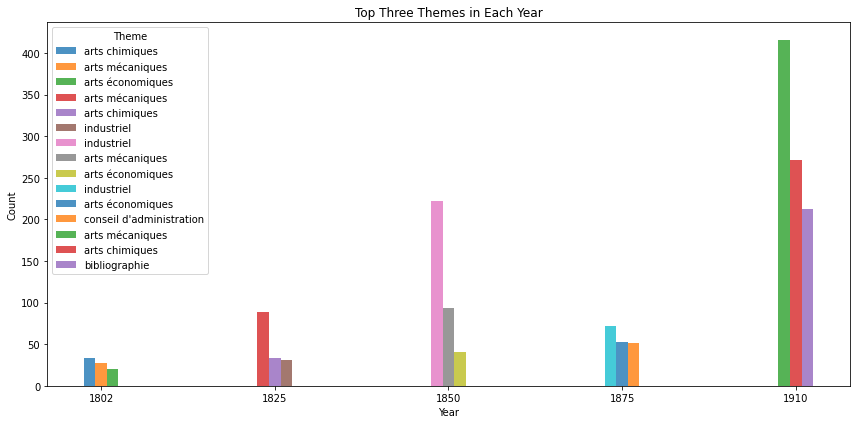

In [0]:
# Step 5: Plot the data as a grouped bar chart
plt.figure(figsize=(12, 6))

# Grouped bar chart parameters
bar_width = 0.2
opacity = 0.8

# Get unique years in the dataset
years = sorted(statics_df['year'].unique())

# Iterate over each year and plot the top three themes as grouped bars
for i, year in enumerate(years):
    df_year = statics_df[statics_df['year'] == year].head(3)  # Select top three themes for each year
    x = i * 3  # Calculate the x position for each year
    
    # Plot each theme as a grouped bar
    for j, theme in enumerate(df_year['theme']):
        y = df_year[df_year['theme'] == theme]['count'].values[0]  # Get the count value
        plt.bar(x + j * bar_width, y, bar_width, alpha=opacity, label=theme)

# Set the x-axis labels and tick positions
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Top Three Themes in Each Year')
plt.xticks([i * 3 + bar_width for i in range(len(years))], years)
plt.legend(title='Theme')
plt.tight_layout()

# Show the modified plot
plt.show()
